# Trajectory Interpolation Example

Example that uses a simple constant-velocity prior over a trajectory that has some fake GPS-like measurements and with interpolation.


In [54]:
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget

from pylgmath import so3op, se3op, Transformation
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
import pysteam

Options:


In [55]:
num_states = 200  # total number of states
dt = 1  # time step

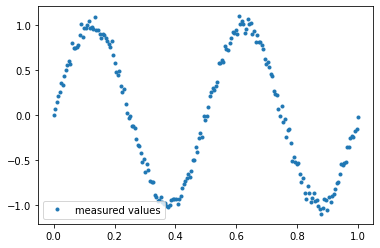

In [56]:
# Create some fake measurements (can consider as gps measurements lat-long-alt being converted to xyz)
fake_meas = np.empty((num_states, 4, 1))
fake_meas[:, 0, 0] = np.linspace(0, 1, num_states)
fake_meas[:, 1, 0] = np.sin(fake_meas[:, 0, 0] * 4 * np.pi) + np.random.normal(scale=0.05, size=fake_meas[:, 1, 0].shape)
fake_meas[:, 2, 0] = 0.0  # z to zero so the problem is 2D
fake_meas[:, 3, 0] = 1.0  # homogeneous coordinate

plt.plot(fake_meas[:, 0], fake_meas[:, 1], '.', label='measured values')
plt.legend()
plt.show()

Create states and wrap them with pysteam variables:


In [63]:
# states with initial conditions and associated timestamps
# T_ba = T_k0 where 0 can be some global frame (e.g. UTM) and k is the vehicle/robot frame at time k
states = [(dt * i, Transformation(C_ba=np.eye(3), r_ba_in_a=fake_meas[i, :3]), np.zeros((6, 1))) for i in range(num_states)]

# wrap states with corresponding steam state variables (no copying!)
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
# state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity

Construct a trajectory with a constant velocity prior for smoothing where knots are states at measurement times:


In [64]:
qcd = np.ones(6)
traj = TrajectoryInterface(qcd=qcd)
for t, T_vi, w_iv_inv in state_vars:
    traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

Construct measurement cost terms:


In [65]:
cost_terms = []
# use a shared L2 loss function and noise model for all cost terms
loss_func = L2LossFunc()
noise_model = StaticNoiseModel(np.eye(3), "information")
for i in range(num_states):
    error_func = P2PErrorEvaluator(T_rq=state_vars[i][1], reference=np.array([[0, 0, 0, 1]]).T, query=fake_meas[i])
    cost_terms.append(WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

Construct the optimization problem and solve:


In [66]:
opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())
opt_prob.add_cost_term(*cost_terms)

solver = GaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

Begin Optimization
------------------
Number of States:  399
Number of Cost Terms:  399
Initial Cost:  8.37021771110547
Iteration:    1  -  Cost:     0.1704
Iteration:    2  -  Cost:     0.1704
Termination Cause:  CONVERGED ABSOLUTE CHANGE


Print out results:


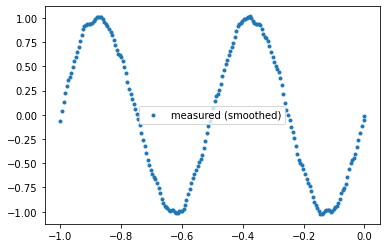

In [48]:
# T_0k = np.array([npla.inv(x.matrix()) for _, x, _ in states])
T_0k = np.array([x.matrix() for _, x, _ in states])
plt.plot(T_0k[:, 0, 3], T_0k[:, 1, 3], '.', label="measured (smoothed)")
# plt.plot(fake_meas[:, 0], fake_meas[:, 1], '.', label='measured values')
plt.legend()
plt.show()

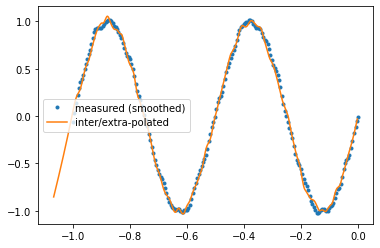

In [67]:
T_k0_interp = [
    traj.get_pose_interpolator(Time(t)).evaluate().matrix() for t in np.linspace(-10*dt,(num_states+10)*dt,1000)
]


# T_0k_interp = np.array([npla.inv(x) for x in T_k0_interp])
T_0k_interp = np.array([x for x in T_k0_interp])
plt.plot(T_0k[:, 0, 3], T_0k[:, 1, 3], '.', label="measured (smoothed)")
plt.plot(T_0k_interp[:, 0, 3], T_0k_interp[:, 1, 3], '-', label="inter/extra-polated")
plt.legend()
plt.show()

In [68]:
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.colors as colors

def plot_ellipse(ax, mean, cov, n_std=2, color="tab:red", alpha=.2, border=False, **kwargs):
    if cov[0,0] < 1e-5**2 or cov[1,1] < 1e-5**2:
        return
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor= (colors.to_rgba(color, alpha) if border==False else (0,0,0,0)),
        edgecolor= (colors.to_rgba(color, alpha) if border==True else (0,0,0,0)),
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    # ax.scatter(*mean, marker='x', color=color)
    return ax.add_patch(ellipse)

In [69]:
covariance = pysteam.solver.Covariance(opt_prob)

x_cov = np.array([covariance.query(x) for _,x,_ in state_vars])
# print(x_cov.shape)

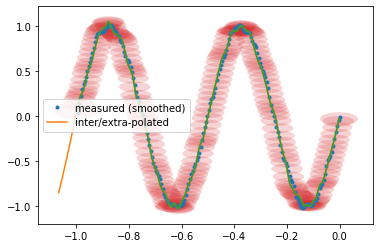

In [73]:
plt.plot(T_0k[:, 0, 3], T_0k[:, 1, 3], '.', label="measured (smoothed)")
plt.plot(T_0k_interp[:, 0, 3], T_0k_interp[:, 1, 3], '-', label="inter/extra-polated")

plt.plot([x[1].matrix()[0,3] for x in states], [x[1].matrix()[1,3] for x in states])

# for x,c in zip(states, x_cov):
#     plot_ellipse(plt.gca(), x[1].matrix()[0:2, 3].flatten(), c[:2,:2], n_std=.1)

for x,c in zip(states, x_cov):
    plot_ellipse(plt.gca(), x[1].matrix()[0:2, 3].flatten(), c[:2,:2], n_std=.1)

plt.legend()
plt.show()